# Manual data analysis 

This notebook gives an example of manually analysing data using the main `qpcr` module.
It makes use of the provided example data in the `Example Data` directory. 


#### Experimental background

The corresponding experimental setup was as follows: 
Levels of Nonsense-mediated mRNA decay (NMD) sensitive (nmd) and insensitive (prot) transcript isoforms of HNRNPL and SRSF11 were measured by qPCR. As normalisers both 28S rRNA and Actin transcript levels were measured. The replicates are biological triplicates and technical douplicates. All measurements from the same qPCR sample were merged into hexaplicates (6 replicates). This was done in two separate HeLa cell lines (one with a specific gene knockout (KO), and one without (WT)), which were both treated to a plasmid-mediated rescue (+) or not (-), leading to four experimental conditions:

| cell line \\ condition | rescue | no rescue |
| ---------------------- | ------ | --------- |
| knockout               | KO+    | KO-       |
| wildtype               | WT+    | WT-       |



#### First Analysis
In this example we will perform a basic Delta-Delta Ct analysis, while manually assembling the analysis pipeline using the classes of the `qpcr` module. We will visualise the results directly using the provided `Plotters` from the `qpcr.Plotters` submodule.

In [1]:
# import the qpcr module
import qpcr
import qpcr.Plotters as qplots

## Step 1 - Setting up the Pipeline
---

### 1.1 Setting up the Reader
We will read the datafiles using the `qpcr.DataReader` class. This is the suggested way as it combines setting up one of the `qpcr.Readers` and generates `qpcr.Assay` objects directly.

> Note
>
> If you checked out the "First Look" code example from the `Getting Started` notebook, you may find that we used the same data there but got a very differntly looking plot at the end. Why's that?? Well, that's because we did not specify any `replicates` information there, so the `qpcr.Assay` objects had to figure these out themselves. They found that always two replicates shared the same identifier (i.e. they found the technical duplicates) and thus decided to group the data according to this. However, our actually desired groupings are based on `replicates = 6` (not the automatically inferrred `replicates = 2`) so we need to specify this explicitly. 

In [2]:
# setup the reader
reader = qpcr.DataReader()

# and define the setup parameters

# NOTE: This is only required if your replicate groups cannot be 
# inferred or deviate from those that would be inferred.

# define the number of replicates for each group (group = condition / qPCR sample)
reps = 6

# define the names of the groups of replicates = names of conditions
# NOTE: The order has to match the order wihtin the raw datafile!
group_names = ["WT-", "WT+", "KO-", "KO+"] 


### 1.2 Setting up the Analyser
Next we set up the the `qpcr.Analyser` that will perform `DeltaCt` computation.

In [3]:
# setup analyser
analyser = qpcr.Analyser()

### 1.3 Setting up the Normaliser
Now we set up the `qpcr.Normaliser` that will subsequently normalise HNRPL and SRSF11 against a combined 28S+actin normaliser.

In [4]:
# setup normaliser
normaliser = qpcr.Normaliser()

## Step 2 - Getting the data
---
Next we get the datafiles (or rather their filepaths). Here, we do this manually. Of course, any more automated process that yields a list of filepaths is also suitable.

In [5]:
# we set up the paths to 28S+actin as our normalisers
normaliser_files = [
                        "./Example Data/28S.csv",
                        "./Example Data/actin.csv"
                ]

# we also set up the paths to the HNRNPL and SRSF11 transcripts
assay_files = [
                    "./Example Data/HNRNPL_nmd.csv",
                    "./Example Data/HNRNPL_prot.csv",
                    "./Example Data/SRSF11_nmd.csv",
                    "./Example Data/SRSF11_prot.csv",
            ]

At this point we also set up empty lists to store the `qpcr.Assay` objects that will be generated after passing the datafiles through `qpcr.DataReader` and `qpcr.Analyser`.

In [6]:
# a list for 28S and actin
normalisers = []
# a list for the HNRNPL and SRSF11 transcript isoforms
assays = []

## Step 3 - Running everything
---
### 3.1 Reading and first `DeltaCt`
Now we finally bring our data and the analysis tools together. To do that we `read` each datafile with the `qpcr.SampleReader` we defined earlier, and then `pipe` it through our defined `qpcr.Analyser`. 

In [7]:
# we first iterate over the normalisers 28S and actin
for norm in normaliser_files:

    # read with the reader
    norm = reader.read(
                        norm, 
                        replicates = reps, 
                        names = group_names 
                    )
    # pipe through analyser
    norm = analyser.pipe(norm)
    
    # now the normaliser is ready and we can append it to the list
    normalisers.append(norm)

# and we do the same for our assays-of-interest of HNRPL and SRSF11
for assay in assay_files:
    assay = reader.read(
                        assay, 
                        replicates = reps, 
                        names = group_names 
                    )
    assay = analyser.pipe(assay)
    assays.append(assay)

### 3.2 Normalisation (i.e. second `DeltaDeltaCt`)
At this point we have two lists of processed `qpcr.Assay` objects that have undergone `DeltaCt` analysis. Now we want to normalise the sample assays against our normalisers to get the second `DeltaDeltaCt`. 
To that end we use the `qpcr.Normaliser` we defined earlier.

In [8]:
# add the assays to the normaliser 
normaliser.link(assays = assays, normalisers = normalisers)

# and run the normalisation
normaliser.normalise()

## Step 4 - Inspecting the Results
---

### 4.1 Get the results
At this point we are basically done. We can get the results of our Delta-Delta-Ct analysis using the `get()` method of the `qpcr.Normaliser`, which will return the final `qpcr.Results` object. By the way, to get a `pandas DataFrame` from this we can simply apply the `get()` method once more. 

In [9]:
# get the final qpcr.Results object
result = normaliser.get()
# get a pandas dataframe of our results
df = result.get()

# inspect the dataframe
df

,id,group,group_name,HNRNPL_nmd_rel_28S+actin,HNRNPL_prot_rel_28S+actin,SRSF11_nmd_rel_28S+actin,SRSF11_prot_rel_28S+actin
0,NK1,0,WT-,1.000000,1.000000,1.000000,1.000000
1,NK1,0,WT-,1.079228,1.035265,0.779165,1.049717
2,NK2,0,WT-,1.088049,1.001209,0.774718,0.994293
3,NK2,0,WT-,1.057239,1.109801,0.870733,1.057239
4,NK3,0,WT-,1.043294,0.993882,1.043294,0.980199
5,NK3,0,WT-,1.032528,1.011279,0.844507,0.976831
6,NK4,1,WT+,6.310374,0.833772,3.726253,1.229205
7,NK4,1,WT+,6.887364,0.879010,4.152419,1.313988
8,NK5,1,WT+,6.422128,0.915766,3.562899,1.151131
9,NK5,1,WT+,7.012172,0.999904,3.757730,1.265635


### 3.1 Visualise the results
The `qpcr` module comes with a handy way to instantly generate a Barchart or DotPlot preview of the results we generated. The `qpcr.Results` class offers the `preview` method as a shortcut to visualise the data directly.

However, to manually preview our results we use the `qpcr.Plotters.PreviewResults` figure class, which can either generate a static image (`matplotlib` generated) or an interactive html plot (made with `plotly`).

In [10]:
# setup both a static and an interactive preview
static_preview = qplots.PreviewResults(mode = "static")
interactive_preview = qplots.PreviewResults(mode = "interactive")

# link our results to the plotters
static_preview.link(result)
interactive_preview.link(result)

The only thing left now is to call the `plot()` method to actually generate a figure. By the way, these previews can be easily customized by passing `**kwargs` to the `plot()` method.

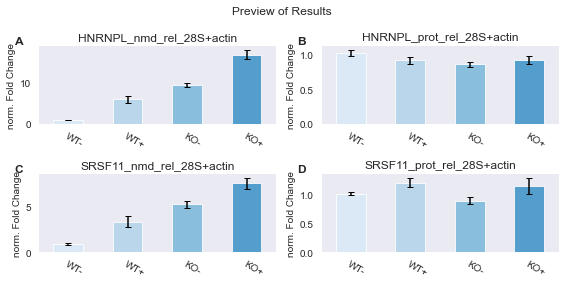

In [11]:
# visualise our static preview
fig = static_preview.plot(
                            figsize = (8,4),
                        )

In [12]:
# visualise our interactive preview
fig2 = interactive_preview.plot(
                                    template = "plotly_dark"
                                )

At this point we have reached the end of this basic tutorial. You are now able to use the basic building blocks of the main `qpcr` module. We have, of course, not talked about the customisibility of each step but have been using default settings. Please, check out the documentation to learn more about how each step can be streamlined to your needs. 

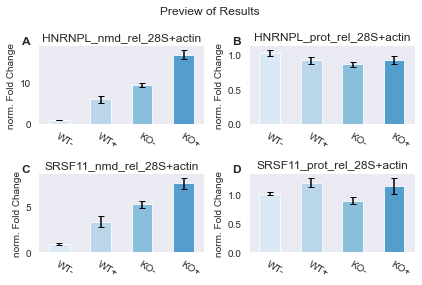

In [13]:
"""
Here is just again our entire workflow with all the code we just wrote:
"""
# get our datafiles
normaliser_files = [
                    "./Example Data/28S.csv",
                    "./Example Data/actin.csv"
                ]

assay_files = [
                "./Example Data/HNRNPL_nmd.csv",
                "./Example Data/HNRNPL_prot.csv",
                "./Example Data/SRSF11_nmd.csv",
                "./Example Data/SRSF11_prot.csv",
            ]

# define our experimental parameters
reps = 6
group_names = ["WT-", "WT+", "KO-", "KO+"] 

# setup the pipeline, starting with the DataReader
reader = qpcr.DataReader()
analyser = qpcr.Analyser()
normaliser = qpcr.Normaliser()

# empty lists for the qpcr.Assay objects 
normalisers = []
assays = []

# now feed in our data

# we first iterate over the normalisers 28S and actin
for norm in normaliser_files:
    norm = reader.read( 
                        norm, 
                        replicates = reps, 
                        names = group_names 
                    )
    norm = analyser.pipe(norm)
    normalisers.append(norm)

# and we do the same for our assays-of-interest of HNRPL and SRSF11
for assay in assay_files:
    assay = reader.read( 
                        assay, 
                        replicates = reps, 
                        names = group_names 
                    )
    assay = analyser.pipe(assay)
    assays.append(assay)

# normalise
normaliser.link(assays = assays, normalisers = normalisers)
normaliser.normalise()

# get results
result = normaliser.get()

# generate a preview
preview = qplots.PreviewResults(mode = "static")
preview.link(result)
fig = preview.plot()

Using these skills you can now develop your own analysis `pipelines`. In fact, this basic analysis workflow is already pre-implemented in the form of the `Basic` and `BasicPlus` pipelines of the `qpcr.Pipes` sub-module. How to use these pipelines is described in the notebook `2_pipeline_tutorial.ipynb`.